In [1]:
import os
import time
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import plotly.express as px

from datetime import datetime

In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [3]:
country_list = ['Canada', 'Chile', 'Mexico', 'Chinese Taipei', 'Hong Kong SAR', 'Japan', 
                'Korea (ROK)', 'Macao, China', 'Maldives', 'Cambodia', 'Indonesia', 'Singapore', 
                'New Zealand', 'USA', 'Thailand', 'Turkey', 'Australia', 'Hawaii', 'Austria', 'Czech']

In [4]:
len(country_list)

20

# GDP
https://docs.google.com/spreadsheets/d/17p7CPobPSyWb5dmVyf_bmZg9Jbh4PjlRPc0G1tJjTUk/edit#gid=501532268
https://databank.worldbank.org/source/world-development-indicators#
https://dbedt.hawaii.gov/economic/datawarehouse/

In [5]:
gdp_df = pd.read_excel('./data/downloaded/GM-GDP per capita - Dataset - v28.xlsx', 
                       sheet_name='data-for-countries-etc-by-year')

In [6]:
gdp_df['name'] = gdp_df['name'].replace({'Taiwan': 'Chinese Taipei', 'Hong Kong, China': 'Hong Kong SAR',
                                        'South Korea': 'Korea (ROK)', 'United States': 'USA', 
                                        'Czech Republic': 'Czech'})

In [7]:
[x for x in country_list if x not in gdp_df['name'].values]

['Macao, China', 'Hawaii']

In [8]:
gdp_df.head()

geo         name  time  Income per person   GDP total  \
0  afg  Afghanistan  1800                683  2239040467   
1  afg  Afghanistan  1801                683  2239040467   
2  afg  Afghanistan  1802                683  2239040467   
3  afg  Afghanistan  1803                683  2239040467   
4  afg  Afghanistan  1804                683  2239040467   

   GDP per capita growth (%)  
0                        0.0  
1                        0.0  
2                        0.0  
3                        0.0  
4                        0.0

In [9]:
macao_gdp = pd.read_excel('./data/downloaded/P_Data_Extract_From_World_Development_Indicators.xlsx', 
                           sheet_name='Data')

In [10]:
macao_gdp = macao_gdp[macao_gdp['Series Code'].isin(['NY.GDP.MKTP.KD', 'NY.GDP.PCAP.KD', 'NY.GDP.PCAP.KD.ZG']) &
                      (macao_gdp['Country Name'] == 'Macao SAR, China')].T

In [11]:
macao_gdp = macao_gdp.reset_index()
macao_gdp.columns = ['time', 'GDP total', 'Income per person', 'GDP per capita growth (%)']
macao_gdp = macao_gdp.iloc[4:].replace('..', np.nan)
macao_gdp['time'] = macao_gdp['time'].str.slice(0, 4)
macao_gdp = macao_gdp.astype(float)
macao_gdp['time'] = macao_gdp['time'].astype(int)
macao_gdp['geo'] = 'mac'
macao_gdp['name'] = 'Macao, China'

In [12]:
# https://www.statista.com/statistics/319467/macau-real-gross-domestic-product-growth-rate/
macao_gdp = pd.concat([macao_gdp.iloc[:-1], pd.DataFrame([[2022, 20417072190.328903, 29184.59, -28.1185722, 'mac', 'Macao, China'],
                                                          [2023, 32442727710.432625, 45514.1058, 55.9535556, 'mac', 'Macao, China'],
                                                          [2024, 39132418164.32383, 54355.5634, 19.4247924, 'mac', 'Macao, China'],
                                                          [2025, 42509545851.904976, 58461.85753074744, 7.554505691587476, 'mac', 'Macao, China']], columns=macao_gdp.columns)], ignore_index=True)

In [13]:
hawaii_gdp = pd.read_excel('./data/downloaded/DBEDT Data Warehouse.xlsx', header=1)

In [14]:
hawaii_gdp = hawaii_gdp[hawaii_gdp['Indicator'].isin(['GDP- All industry total', 
                                                      'Per Capita Personal Income'])].T

In [15]:
hawaii_gdp = hawaii_gdp.iloc[3:-1]
hawaii_gdp = hawaii_gdp.reset_index()
hawaii_gdp.columns = ['time', 'GDP total', 'Income per person',]
hawaii_gdp['GDP total'] = hawaii_gdp['GDP total'].str.replace(',', '')
hawaii_gdp['Income per person'] = hawaii_gdp['Income per person'].str.replace(',', '')
hawaii_gdp = hawaii_gdp.astype(float)
hawaii_gdp['time'] = hawaii_gdp['time'].astype(int)
hawaii_gdp['GDP total'] = hawaii_gdp['GDP total'] * 1000000
hawaii_gdp['geo'] = 'haw'
hawaii_gdp['name'] = 'Hawaii'
hawaii_gdp['GDP per capita growth (%)'] = hawaii_gdp['Income per person'].pct_change() * 100

In [16]:
# https://dbedt.hawaii.gov/economic/qser/outlook-economy/
hawaii_gdp = pd.concat([hawaii_gdp, pd.DataFrame([[2023, 99986738400.0, 69495.0, 'haw', 'Hawaii', 13.6003269309], 
                                                  [2024, 101986473168, 70885, 'haw', 'Hawaii', 2.0001439],
                                                  [2025, 103312297319, 71735, 'haw', 'Hawaii', 1.1991253]], columns=hawaii_gdp.columns)], ignore_index=True)

In [17]:
gdp_df = pd.concat([gdp_df, macao_gdp, hawaii_gdp], axis=0, ignore_index=True)

In [18]:
gdp_df = gdp_df[gdp_df['name'].isin(country_list + ['China']) & gdp_df['time'].between(1970, 2023)].reset_index(drop=True)
gdp_df = gdp_df.drop(columns='geo').rename(columns={'name': 'Country', 'time': 'Year',
                                                    'Income per person': 'GDP Per Capita'})


In [19]:
# since we cannot use their forecast, we simply use exponential smoothing to extrapolate 2 years ahead
from statsmodels.tsa.api import ExponentialSmoothing

temp = []
for country in gdp_df['Country'].unique():
    temp_df = gdp_df[gdp_df['Country'] == country].copy()
    temp_df['Year'] = pd.to_datetime(temp_df['Year'], format='%Y')
    temp_df = temp_df.set_index('Year')
    gdp_fit = ExponentialSmoothing(temp_df['GDP total'].dropna(), trend="add", damped_trend=True, use_boxcox=True, freq='AS').fit()
    gdppc_fit = ExponentialSmoothing(temp_df['GDP Per Capita'].dropna(), trend="add", damped_trend=True, use_boxcox=True, freq='AS').fit()
    forecast1 = gdp_fit.forecast(2).rename("GDP total")
    forecast2 = gdppc_fit.forecast(2).rename("GDP Per Capita")
    f_df = pd.concat([forecast1, forecast2], axis=1)
    f_df['Country'] = country
    temp_df = pd.concat([temp_df, f_df])
    temp_df['Year'] = temp_df.index.year
    temp.append(temp_df)
gdp_df = pd.concat(temp, ignore_index=True)

/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/scratch/zt0029

In [20]:
gdp_df.to_csv('./data/GDP.csv', index=False)

In [21]:
gdp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1173 entries, 0 to 1172
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Country                    1173 non-null   object 
 1   GDP Per Capita             1164 non-null   float64
 2   GDP total                  1137 non-null   float64
 3   GDP per capita growth (%)  1121 non-null   float64
 4   Year                       1173 non-null   int32  
dtypes: float64(3), int32(1), object(1)
memory usage: 41.4+ KB


In [23]:
def plot_data(df, column='GDP Per Capita', country=None, by_month=False, date_col='Year'):
    df = df.copy()
    fig, ax = plt.subplots(figsize=(12, 6))
    if country is not None:
        if isinstance(country, str):
            country = [country]
        df = df[df['Country'].isin(country)]
    else:
        country = df['Country'].unique()
    # sns.lineplot(data=df, x='Year', y=column, hue='Country', ax=ax)
    
    if by_month:
        df['Year'], df['Month'] = df[date_col].dt.year.astype(str), df['Date'].dt.month
        if len(country) == 1:
            sns.lineplot(data=df, x='Month', y=column, hue='Year', ax=ax)
        else:
            sns.lineplot(data=df, x='Month', y=column, hue='Country', style='Year', ax=ax)
    else:
        sns.lineplot(data=df, x=date_col, y=column, hue='Country', ax=ax)
    
    plt.xticks(rotation=45, ha='right')
    return df

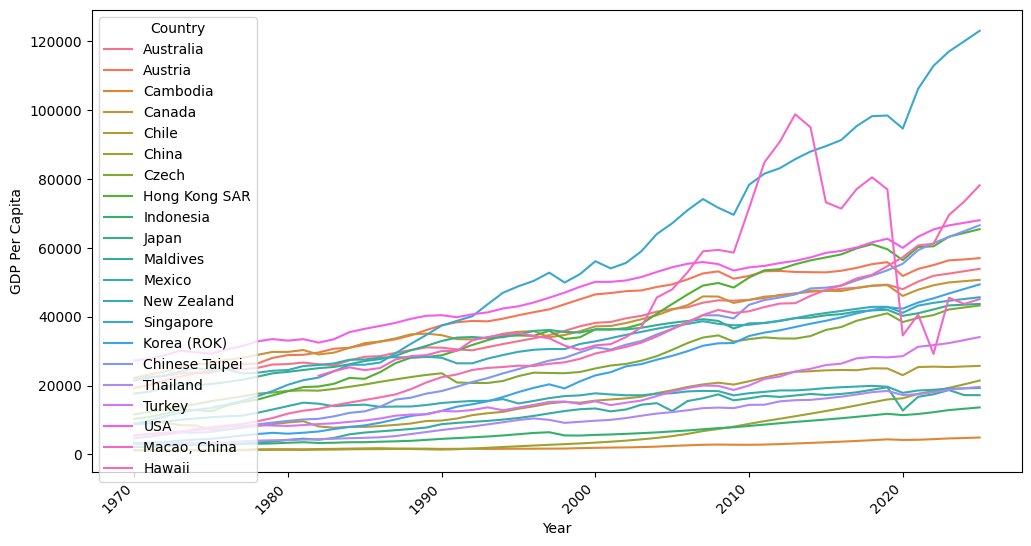

In [24]:
_ = plot_data(gdp_df)

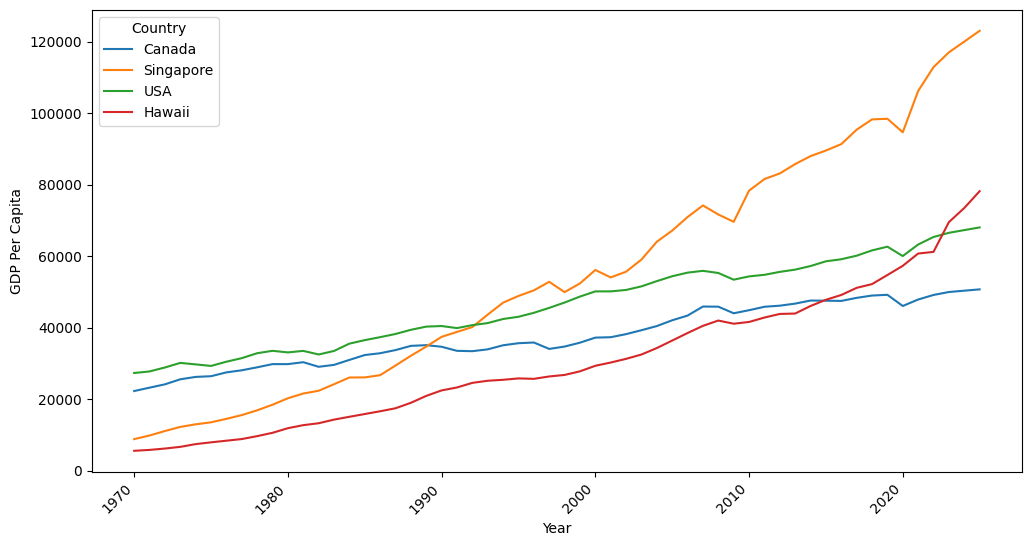

In [25]:
_ = plot_data(gdp_df, country=['USA', 'Singapore', 'Canada', 'Hawaii'])

In [26]:
gdp_df.tail()

Country  GDP Per Capita     GDP total  GDP per capita growth (%)  Year
1168  Hawaii    60711.000000  9.109610e+10                   5.997276  2021
1169  Hawaii    61175.000000  9.821880e+10                   0.764277  2022
1170  Hawaii    69495.000000  9.998674e+10                  13.600327  2023
1171  Hawaii    73444.897462  1.006821e+11                        NaN  2024
1172  Hawaii    78146.131140  1.029386e+11                        NaN  2025

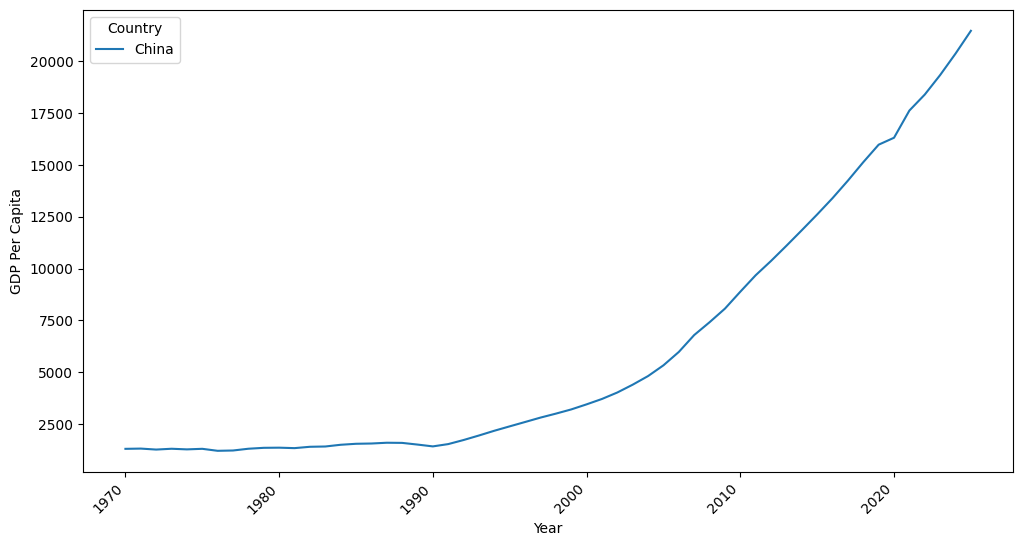

In [27]:
_ = plot_data(gdp_df, country=['China'])

# Population
https://docs.google.com/spreadsheets/d/1c1luQNdpH90tNbMIeU7jD__59wQ0bdIGRFpbMm8ZBTk/edit#gid=501532268
https://databank.worldbank.org/source/world-development-indicators#
https://dbedt.hawaii.gov/economic/datawarehouse/

In [63]:
pop_df = pd.read_excel('./data/downloaded/GM-Population - Dataset - v6.xlsx', 
                       sheet_name='data-for-countries-etc-by-year')

In [64]:
pop_df['name'] = pop_df['name'].replace({'Taiwan': 'Chinese Taipei', 'Hong Kong, China': 'Hong Kong SAR',
                                        'South Korea': 'Korea (ROK)', 'United States': 'USA', 
                                        'Czech Republic': 'Czech'})

In [65]:
[x for x in country_list if x not in pop_df['name'].values]

['Macao, China', 'Hawaii']

In [66]:
macao_pop = pd.read_excel('./data/downloaded/P_Data_Extract_From_World_Development_Indicators.xlsx', 
                           sheet_name='Data')

In [67]:
macao_pop = macao_pop[macao_pop['Series Code'].isin(['SP.POP.TOTL']) &
                      (macao_pop['Country Name'] == 'Macao SAR, China')].T

In [68]:
macao_pop = macao_pop.reset_index()
macao_pop.columns = ['time', 'Population']
macao_pop = macao_pop.iloc[4:].replace('..', np.nan)
macao_pop['time'] = macao_pop['time'].str.slice(0, 4)
macao_pop = macao_pop.astype(float)
macao_pop['time'] = macao_pop['time'].astype(int)
macao_pop['geo'] = 'mac'
macao_pop['name'] = 'Macao, China'

In [69]:
#https://countrymeters.info/en/Macau#population_2022
macao_pop = pd.concat([macao_pop.iloc[:-1], pd.DataFrame([[2022, 699584, 'mac', 'Macao, China'], [2023, 712806, 'mac', 'Macao, China'], [2024, 719934, 'mac', 'Macao, China'],
                                                          [2025, 727133, 'mac', 'Macao, China']], columns=macao_pop.columns)], ignore_index=True)

In [70]:
hawaii_pop = pd.read_excel('./data/downloaded/DBEDT Data Warehouse.xlsx', header=1)

In [71]:
hawaii_pop = hawaii_pop[hawaii_pop['Indicator'].isin(['Total Resident Population'])].T

In [72]:
hawaii_pop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87 entries, Indicator to Source
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   1       87 non-null     object
dtypes: object(1)
memory usage: 3.4+ KB


In [73]:
hawaii_pop = hawaii_pop.iloc[3:-1]
hawaii_pop = hawaii_pop.reset_index()
hawaii_pop.columns = ['time', 'Population',]
hawaii_pop['Population'] = hawaii_pop['Population'].astype(float)
hawaii_pop = hawaii_pop.astype(float)
hawaii_pop['time'] = hawaii_pop['time'].astype(int)
hawaii_pop['geo'] = 'haw'
hawaii_pop['name'] = 'Hawaii'

In [74]:
# https://dbedt.hawaii.gov/economic/qser/outlook-economy/
hawaii_pop = pd.concat([hawaii_pop, pd.DataFrame([[2023, 1438755, 'haw', 'Hawaii'], [2024, 1438755, 'haw', 'Hawaii'], [2025, 1440194, 'haw', 'Hawaii']], columns=hawaii_pop.columns)], ignore_index=True)

In [75]:
pop_df = pd.concat([pop_df, macao_pop, hawaii_pop], axis=0, ignore_index=True)

In [76]:
pop_df = pop_df[pop_df['name'].isin(country_list + ['China']) & pop_df['time'].between(1970, 2023)].reset_index(drop=True)
pop_df = pop_df.drop(columns='geo').rename(columns={'name': 'Country', 'time': 'Year'})

In [77]:
# since we cannot use their forecast, we simply use exponential smoothing to extrapolate 2 years ahead

temp = []
for country in pop_df['Country'].unique():
    temp_df = pop_df[pop_df['Country'] == country].copy()
    temp_df['Year'] = pd.to_datetime(temp_df['Year'], format='%Y')
    temp_df = temp_df.set_index('Year')
    pop_fit = ExponentialSmoothing(temp_df['Population'].dropna(), trend="add", damped_trend=True, freq='AS').fit()
    forecast = pop_fit.forecast(2).rename("Population")
    f_df = pd.DataFrame(forecast)
    f_df['Country'] = country
    temp_df = pd.concat([temp_df, f_df])
    temp_df['Year'] = temp_df.index.year
    temp.append(temp_df)
pop_df = pd.concat(temp, ignore_index=True)

/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/scratch/zt0029

In [78]:
pop_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1173 entries, 0 to 1172
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Country     1173 non-null   object 
 1   Population  1173 non-null   float64
 2   Year        1173 non-null   int32  
dtypes: float64(1), int32(1), object(1)
memory usage: 23.0+ KB


In [80]:
pop_df.to_csv('./data/Population.csv', index=False)

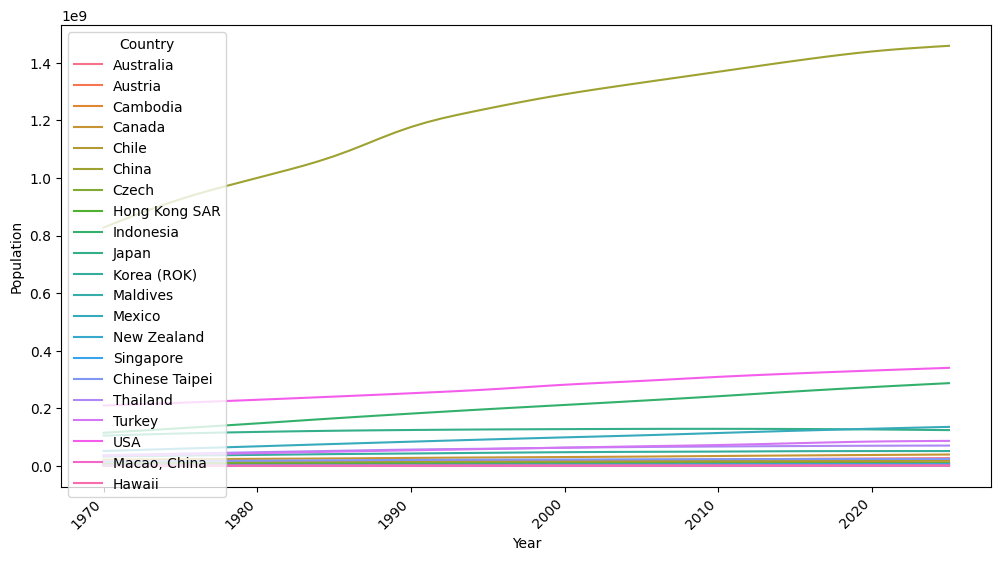

In [81]:
_ = plot_data(pop_df, column='Population')

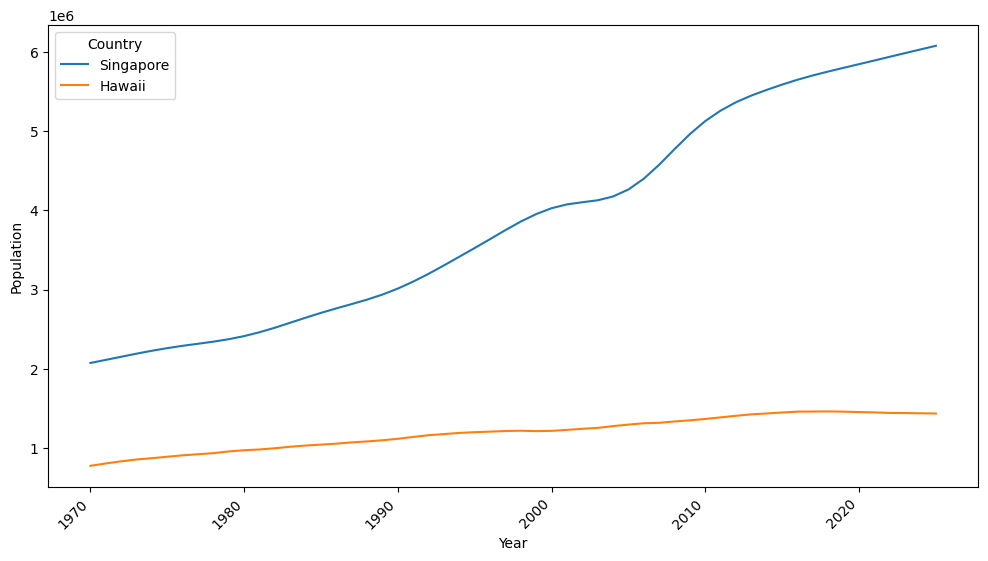

In [82]:
_ = plot_data(pop_df, column='Population', country=['Singapore', 'Hawaii'])

# Tourism Indicator
Not used
https://www.unwto.org/tourism-statistics/key-tourism-statistics

In [46]:
hotel_df = pd.read_excel('./data/downloaded/unwto-tourism-industries-data.xlsx', header=2)

In [47]:
kv = {'CANADA': 'Canada', 'CHILE': 'Chile', 'MEXICO': 'Mexico', 'TAIWAN PROVINCE OF CHINA': 'Chinese Taipei', 'HONG KONG, CHINA': 'Hong Kong SAR', 'JAPAN': 'Japan',
      'KOREA, REPUBLIC OF': 'Korea (ROK)', 'MACAO, CHINA': 'Macao, China', 'MALDIVES': 'Maldives', 'CAMBODIA': 'Cambodia', 'INDONESIA': 'Indonesia', 'SINGAPORE': 'Singapore',
      'NEW ZEALAND': 'New Zealand', 'UNITED STATES OF AMERICA': 'USA', 'THAILAND': 'Thailand', 'TÜRKIYE': 'Turkey', 'AUSTRALIA': 'Australia', 'AUSTRIA': 'Austria', 'CZECH REPUBLIC (CZECHIA)': 'Czech'}
tour_df = []
for k, v in kv.items():
    idx = hotel_df[hotel_df['Basic data and indicators'] == k].index[0]
    temp_df = hotel_df.iloc[idx:]
    noe = temp_df[temp_df['Unnamed: 5'] == 'Number of establishments'].iloc[0, 10:37].replace('..', np.nan).astype(float)
    nor = temp_df[temp_df['Unnamed: 5'] == 'Number of rooms'].iloc[0, 10:37].replace('..', np.nan).astype(float)
    temp_df = pd.DataFrame({'Country': v, 'Hotels count': noe, 'Rooms count': nor})
    temp_df = temp_df.reset_index(names='Year')
    if k == 'JAPAN':
        temp_df.loc[temp_df['Year'].between(2008, 2009), ['Hotels count', 'Rooms count']] = np.nan
    tour_df.append(temp_df)
tour_df = pd.concat(tour_df, ignore_index=True)

In [48]:
[x for x in country_list if x not in tour_df['Country'].unique()]

['Hawaii']

In [49]:
tour_df.to_csv('./data/TourismIndicator.csv', index=False)

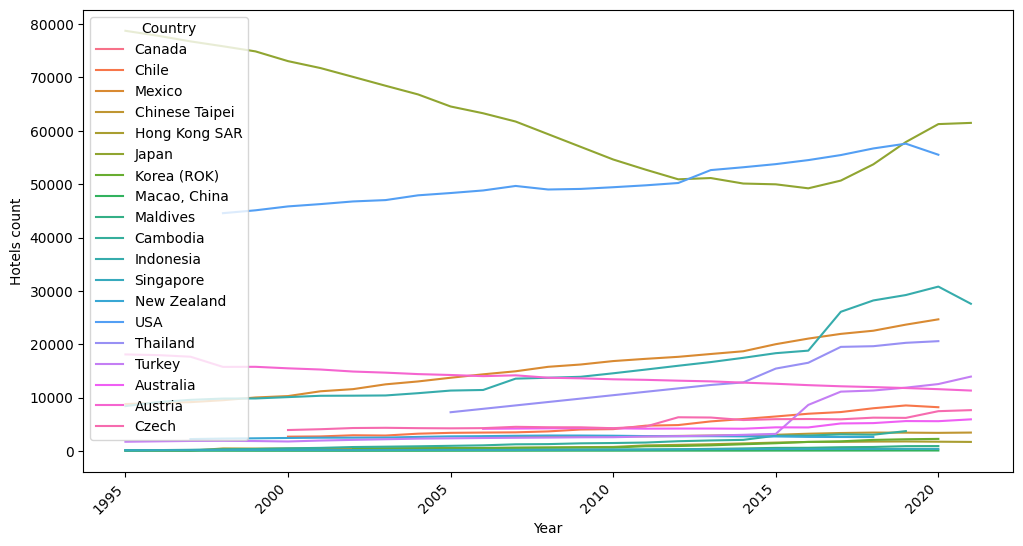

In [50]:
_ = plot_data(tour_df, column='Hotels count')

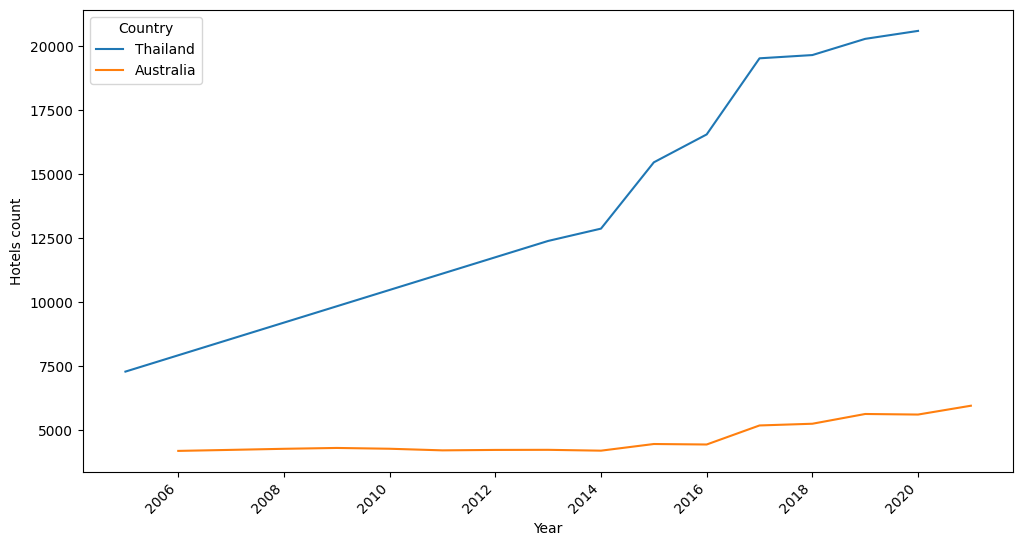

In [51]:
_ = plot_data(tour_df, country=['Australia', 'Thailand'], column='Hotels count')

# Covid Data
https://covid19.who.int/data

In [52]:
covid_df = pd.read_csv('https://covid19.who.int/WHO-COVID-19-global-data.csv')

In [53]:
kv = {'Canada': 'Canada', 'Chile': 'Chile', 'Mexico': 'Mexico', 'Japan': 'Japan', 'Hong Kong SAR': 'Hong Kong SAR', 'Chinese Taipei': 'Chinese Taipei', 'Macao, China': 'Macao, China',
      'Republic of Korea': 'Korea (ROK)', 'Maldives': 'Maldives', 'Cambodia': 'Cambodia', 'INDONESIA': 'Indonesia', 'SINGAPORE': 'Singapore', 'Hawaii': 'Hawaii',
      'New Zealand': 'New Zealand', 'United States of America': 'USA', 'Thailand': 'Thailand', 'Türkiye': 'Turkey', 'Australia': 'Australia', 'Austria': 'Austria', 'Czechia': 'Czech'}

In [54]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306678 entries, 0 to 306677
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Date_reported      306678 non-null  object
 1   Country_code       305384 non-null  object
 2   Country            306678 non-null  object
 3   WHO_region         306678 non-null  object
 4   New_cases          306678 non-null  int64 
 5   Cumulative_cases   306678 non-null  int64 
 6   New_deaths         306678 non-null  int64 
 7   Cumulative_deaths  306678 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 18.7+ MB


In [55]:
headers = {
    'sec-ch-ua': '"Not.A/Brand";v="8", "Chromium";v="114", "Google Chrome";v="114"',
    'Referer': 'https://coronalevel.com/China/Hong_Kong/',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36',
    'sec-ch-ua-platform': '"macOS"',
}

response = requests.get('https://coronalevel.com/China/Hong_Kong/datagroup-1d-v3.json', headers=headers)
hk_covid = response.json()
for series in hk_covid['series']:
    if series['name'] == 'New cases (daily change)':
        hk_covid_new = series['data']
    if series['name'] == 'New deaths (daily change)':
        hk_covid_death = series['data']
hk_covid_df = pd.DataFrame(hk_covid_new, columns=['Date', 'New_cases'])
hk_covid_df['Date'] = pd.to_datetime(hk_covid_df['Date'], unit='ms').dt.strftime('%Y-%m-%d')
hk_covid_df2 = pd.DataFrame(hk_covid_death, columns=['Date', 'New_deaths'])
hk_covid_df2['Date'] = pd.to_datetime(hk_covid_df2['Date'], unit='ms').dt.strftime('%Y-%m-%d')
hk_covid_df = pd.concat([hk_covid_df.set_index('Date'), hk_covid_df2.set_index('Date')], axis=1).reset_index(names='Date_reported')
hk_covid_df['Country'] = 'Hong Kong SAR'

In [56]:
headers = {
    'sec-ch-ua': '"Not.A/Brand";v="8", "Chromium";v="114", "Google Chrome";v="114"',
    'Referer': 'https://coronalevel.com/Taiwan/',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36',
    'sec-ch-ua-platform': '"macOS"',
}

response = requests.get('https://coronalevel.com/Taiwan/datagroup-1d-v3.json', headers=headers)
tw_covid = response.json()
for series in tw_covid['series']:
    if series['name'] == 'New cases (daily change)':
        tw_covid_new = series['data']
    if series['name'] == 'New deaths (daily change)':
        tw_covid_death = series['data']
tw_covid_df = pd.DataFrame(tw_covid_new, columns=['Date', 'New_cases'])
tw_covid_df['Date'] = pd.to_datetime(tw_covid_df['Date'], unit='ms').dt.strftime('%Y-%m-%d')
tw_covid_df2 = pd.DataFrame(tw_covid_death, columns=['Date', 'New_deaths'])
tw_covid_df2['Date'] = pd.to_datetime(tw_covid_df2['Date'], unit='ms').dt.strftime('%Y-%m-%d')
tw_covid_df = pd.concat([tw_covid_df.set_index('Date'), tw_covid_df2.set_index('Date')], axis=1).reset_index(names='Date_reported')
tw_covid_df['Country'] = 'Chinese Taipei'

In [57]:
headers = {
    'sec-ch-ua': '"Not.A/Brand";v="8", "Chromium";v="114", "Google Chrome";v="114"',
    'Referer': 'https://coronalevel.com/China/Macau/',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36',
    'sec-ch-ua-platform': '"macOS"',
}

response = requests.get('https://coronalevel.com/China/Macau/datagroup-1d-v3.json', headers=headers)
mc_covid = response.json()
for series in mc_covid['series']:
    if series['name'] == 'New cases (daily change)':
        mc_covid_new = series['data']
    if series['name'] == 'New deaths (daily change)':
        mc_covid_death = series['data']
mc_covid_df = pd.DataFrame(mc_covid_new, columns=['Date', 'New_cases'])
mc_covid_df['Date'] = pd.to_datetime(mc_covid_df['Date'], unit='ms').dt.strftime('%Y-%m-%d')
mc_covid_df2 = pd.DataFrame(mc_covid_death, columns=['Date', 'New_deaths'])
mc_covid_df2['Date'] = pd.to_datetime(mc_covid_df2['Date'], unit='ms').dt.strftime('%Y-%m-%d')
mc_covid_df = pd.concat([mc_covid_df.set_index('Date'), mc_covid_df2.set_index('Date')], axis=1).reset_index(names='Date_reported')
mc_covid_df['Country'] = 'Macao, China'

In [58]:
headers = {
    'sec-ch-ua': '"Not.A/Brand";v="8", "Chromium";v="114", "Google Chrome";v="114"',
    'Referer': 'https://coronalevel.com/United_States/Hawaii/',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36',
    'sec-ch-ua-platform': '"macOS"',
}

response = requests.get('https://coronalevel.com/United_States/Hawaii/datagroup-1d-v3.json', headers=headers)
hw_covid = response.json()
for series in hw_covid['series']:
    if series['name'] == 'New cases (daily change)':
        hw_covid_new = series['data']
    if series['name'] == 'New deaths (daily change)':
        hw_covid_death = series['data']
hw_covid_df = pd.DataFrame(hw_covid_new, columns=['Date', 'New_cases'])
hw_covid_df['Date'] = pd.to_datetime(hw_covid_df['Date'], unit='ms').dt.strftime('%Y-%m-%d')
hw_covid_df2 = pd.DataFrame(hw_covid_death, columns=['Date', 'New_deaths'])
hw_covid_df2['Date'] = pd.to_datetime(hw_covid_df2['Date'], unit='ms').dt.strftime('%Y-%m-%d')
hw_covid_df = pd.concat([hw_covid_df.set_index('Date'), hw_covid_df2.set_index('Date')], axis=1).reset_index(names='Date_reported')
hw_covid_df['Country'] = 'Hawaii'

In [59]:
covid_df = pd.concat([covid_df[['Date_reported', 'Country', 'New_cases', 'New_deaths']], hk_covid_df, mc_covid_df, tw_covid_df, hw_covid_df], ignore_index=True)

In [60]:
covid_df['Date'] = pd.to_datetime(covid_df['Date_reported'].str.slice(0, -3))
covid_df = covid_df.groupby(['Country', 'Date'])[['New_cases', 'New_deaths']].sum().reset_index()

In [61]:
covid_df['Country'] = covid_df['Country'].replace(kv)
covid_df = covid_df[covid_df['Country'].isin(kv.values())].reset_index(drop=True).rename(columns={'New_cases': 'New Cases', 'New_deaths': 'New Deaths'})

In [62]:
[x for x in country_list if x not in covid_df['Country'].unique()]

[]

In [63]:
covid_df['New Cases'] = covid_df['New Cases'].mask(covid_df['New Cases'] < 0, np.nan).interpolate(limit_area='inside')
covid_df['New Deaths'] = covid_df['New Deaths'].mask(covid_df['New Deaths'] < 0, np.nan).interpolate(limit_area='inside')
covid_df

Country       Date  New Cases  New Deaths
0    Australia 2020-01-01        9.0         0.0
1    Australia 2020-02-01       16.0         0.0
2    Australia 2020-03-01     4334.0        21.0
3    Australia 2020-04-01     2387.0        74.0
4    Australia 2020-05-01      439.0        12.0
..         ...        ...        ...         ...
837        USA 2023-03-01   678002.0      7909.0
838        USA 2023-04-01   568838.0      7009.0
839        USA 2023-05-01   170425.0      3089.0
840        USA 2023-06-01        0.0         0.0
841        USA 2023-07-01        0.0         0.0

[842 rows x 4 columns]

In [64]:
covid_df.to_csv('./data/CovidCases.csv', index=False)

In [65]:
def plot_data_date(df, column='New Cases', country=None, by_month=False):
    fig, ax = plt.subplots(figsize=(12, 6))
    if country is not None:
        if isinstance(country, str):
            country = [country]
        for c in country:
            assert c in df['Country'].unique()
        df = df[df['Country'].isin(country)]
    else:
        country = df['Country'].unique()

    if by_month:
        df['Year'], df['Month'] = df['Date'].dt.year.astype(str), df['Date'].dt.month
        if len(country) == 1:
            sns.lineplot(data=df, x='Month', y=column, hue='Year', ax=ax)
        else:
            sns.lineplot(data=df, x='Month', y=column, hue='Country', style='Year', ax=ax)
    else:
        sns.lineplot(data=df, x='Date', y=column, hue='Country', ax=ax)
    
    plt.xticks(rotation=45, ha='right')
    return df

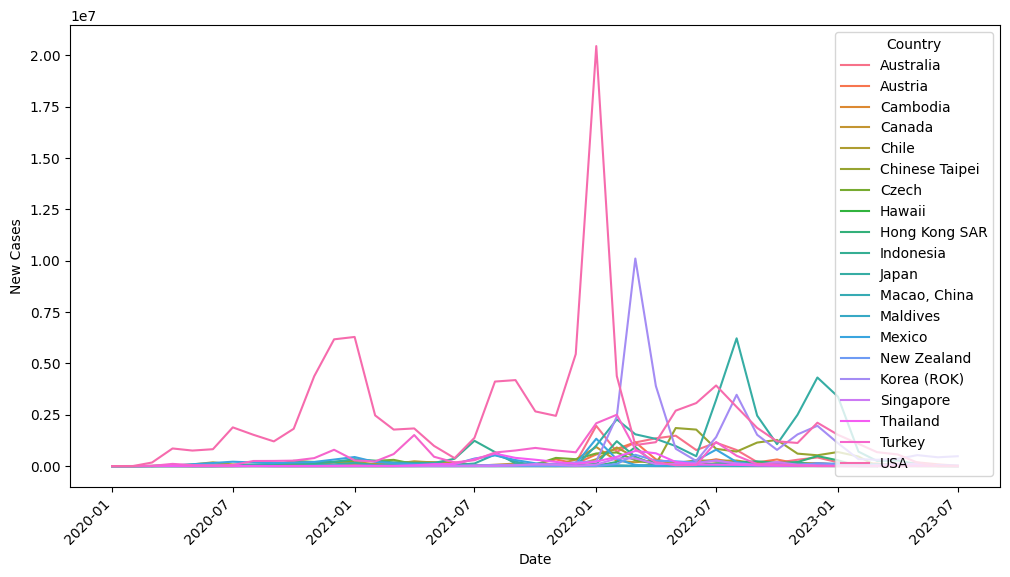

In [66]:
_ = plot_data_date(covid_df, column='New Cases')

(array([1995., 2000., 2005., 2010., 2015., 2020., 2025.]),
 [Text(1995.0, 0, '1995'),
  Text(2000.0, 0, '2000'),
  Text(2005.0, 0, '2005'),
  Text(2010.0, 0, '2010'),
  Text(2015.0, 0, '2015'),
  Text(2020.0, 0, '2020'),
  Text(2025.0, 0, '2025')])

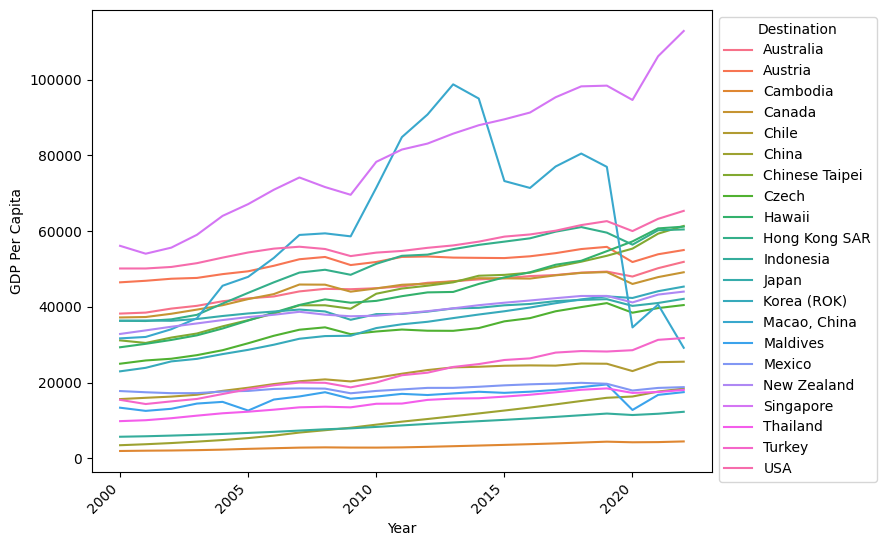

In [67]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(data=gdp_df[gdp_df['Year'].between(2000, 2022)].rename(columns={'Country': 'Destination'}).sort_values(by='Destination'), x='Year', y='GDP Per Capita', hue='Destination', ax=ax)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=45, ha='right')

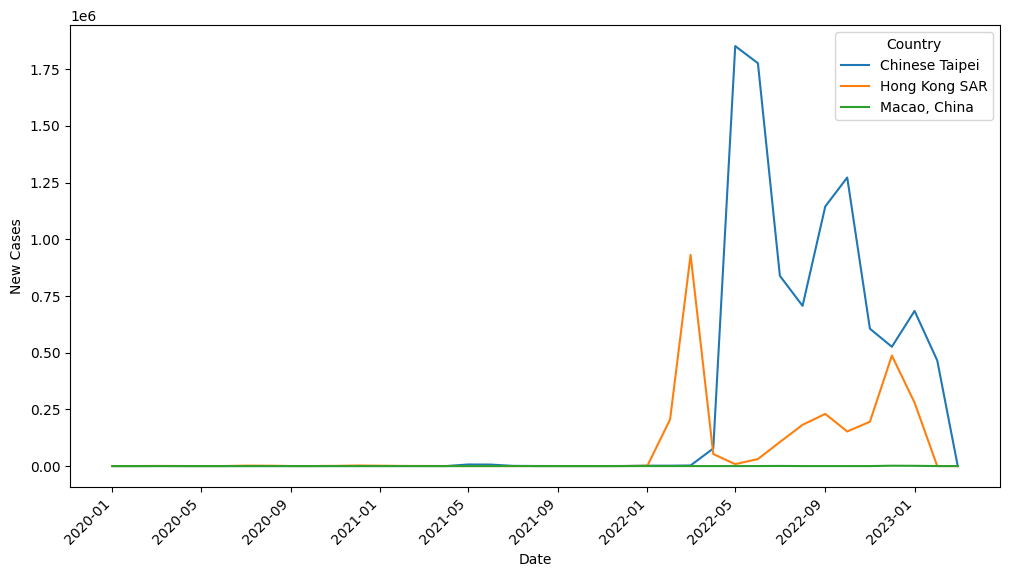

In [68]:
_ = plot_data_date(covid_df, column='New Cases', country=['Chinese Taipei', 'Hong Kong SAR', 'Macao, China'])

# Travel Policy
https://ourworldindata.org/grapher/international-travel-covid?time=latest
https://github.com/OxCGRT/covid-policy-tracker/tree/master/data
0 - no restrictions
1 - screening arrivals
2 - quarantine arrivals from some or all regions
3 - ban arrivals from some regions
4 - ban on all regions or total border closure
Blank - no data

In [69]:
travel_df = pd.read_csv('https://github.com/OxCGRT/covid-policy-tracker/raw/master/data/OxCGRT_nat_latest.csv')[['CountryName', 'Date', 'C8EV_International travel controls']]

In [70]:
travel_df = travel_df.rename(columns={'CountryName': 'Country', 'C8EV_International travel controls': 'Travel Policy'})
# manually add data
add_data = [['Chile', 20230503, 0.0], ['Chinese Taipei', 20230214, 0.0], ['Hong Kong SAR', 20230206, 0.0], ['Indonesia', 20230614, 0.0], ['Japan', 20230501, 0.0], ['Macao, China', 20230206, 0.0],
            ['Mexico', 20230101, 0.0], ['Singapore', 20230213, 0.0], ['USA', 20230208, 0.0],
            ['Maldives', 20200101, 0.0], ['Maldives', 20200327, 4.0], ['Maldives', 20200526, 3.0], ['Maldives', 20200715, 1.0], ['Maldives', 20210512, 3.0], 
            ['Maldives', 20210715, 1.0], ['Maldives', 20211128, 3.0], ['Maldives', 20220131, 1.0], ['Maldives', 20220305, 0.0]]
travel_df = pd.concat([travel_df, pd.DataFrame(add_data, columns=['Country', 'Date', 'Travel Policy'])], ignore_index=True)
travel_df['Date'] = pd.to_datetime(travel_df['Date'].astype(str).str.slice(0, -2), format='%Y%m')

In [71]:
travel_df['Country'] = travel_df['Country'].replace({'Taiwan': 'Chinese Taipei', 'Hong Kong': 'Hong Kong SAR', 'South Korea': 'Korea (ROK)',
                                                     'Macao': 'Macao, China', 'United States': 'USA', 'Czech Republic': 'Czech'})
travel_df = travel_df[travel_df['Country'].isin(country_list)].reset_index(drop=True)
travel_df = travel_df.groupby(['Country', 'Date'])['Travel Policy'].agg(lambda x: max(pd.Series.mode(x))).reset_index()

In [72]:
[x for x in country_list if x not in travel_df['Country'].unique()]

['Hawaii']

In [73]:
travel_df.to_csv('./data/TravelPolicy.csv', index=False)

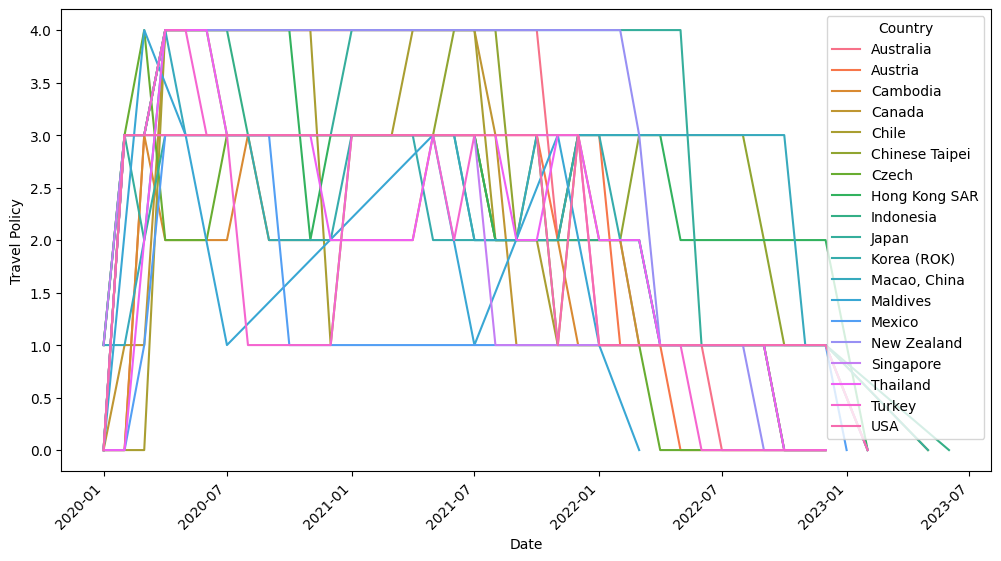

In [74]:
_ = plot_data_date(travel_df, column='Travel Policy')

# FSI
https://fragilestatesindex.org/excel/

In [75]:
fsi_dir = './data/downloaded/FSI'
fsi_df = []
for f in os.listdir(fsi_dir):
    temp_df = pd.read_excel(os.path.join(fsi_dir, f))[['Country', 'Year', 'Total']]
    temp_df['Country'] = temp_df['Country'].replace({'South Korea': 'Korea (ROK)', 'United States': 'USA', 'Czech Republic': 'Czech'})
    temp_df = temp_df[temp_df['Country'].isin(country_list + ['China'])]
    if temp_df['Year'].dtype == np.int64:
        temp_df['Year'] = pd.to_datetime(temp_df['Year'].astype(str), format='%Y')
    fsi_df.append(temp_df)
fsi_df = pd.concat(fsi_df, ignore_index=True).rename(columns={'Total': 'FSI Index'})

In [76]:
[x for x in country_list if x not in fsi_df['Country'].unique()]

['Chinese Taipei', 'Hong Kong SAR', 'Macao, China', 'Hawaii']

In [77]:
fsi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295 entries, 0 to 294
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Country    295 non-null    object        
 1   Year       295 non-null    datetime64[ns]
 2   FSI Index  295 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 7.0+ KB


In [78]:
fsi_df.to_csv('./data/FSI.csv', index=False)

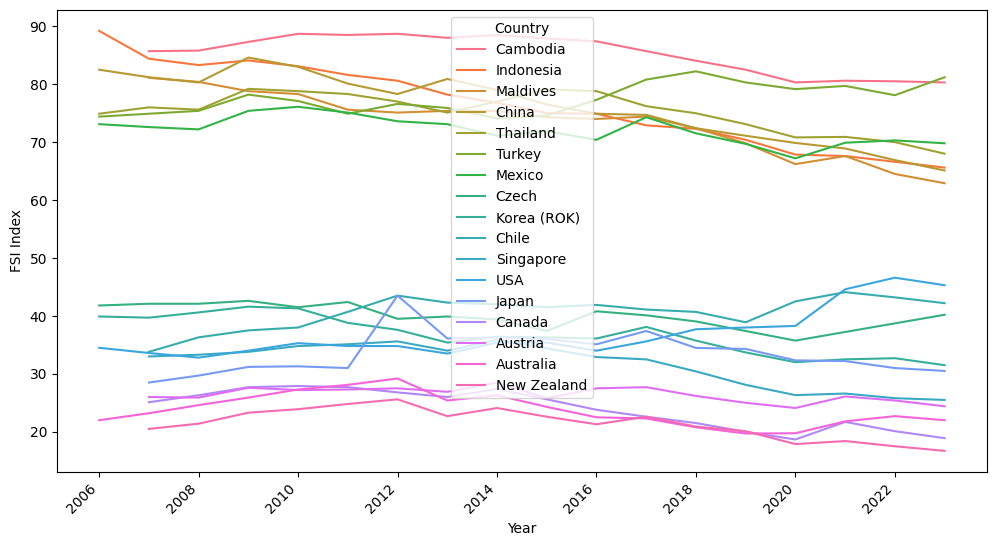

In [79]:
_ = plot_data(fsi_df, column='FSI Index')

In [80]:
fsi_df.sort_values(by=['Year', 'Country'])

Country       Year  FSI Index
260    Australia 2006-01-01       22.0
253        China 2006-01-01       82.5
257        Czech 2006-01-01       41.8
252    Indonesia 2006-01-01       89.2
258  Korea (ROK) 2006-01-01       39.9
..           ...        ...        ...
33   New Zealand 2023-01-01       16.7
29     Singapore 2023-01-01       25.5
20      Thailand 2023-01-01       68.0
17        Turkey 2023-01-01       81.2
24           USA 2023-01-01       45.3

[295 rows x 3 columns]

# Geographical Data
https://github.com/google/dspl/tree/master

In [81]:
geo_df = pd.read_csv('https://github.com/google/dspl/raw/master/samples/google/canonical/countries.csv')

In [82]:
geo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245 entries, 0 to 244
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   country    244 non-null    object 
 1   latitude   244 non-null    float64
 2   longitude  244 non-null    float64
 3   name       245 non-null    object 
dtypes: float64(2), object(2)
memory usage: 7.8+ KB


In [83]:
geo_df['name'] = geo_df['name'].replace({'Taiwan': 'Chinese Taipei', 'Hong Kong': 'Hong Kong SAR', 'Macau': 'Macao, China', 'United States': 'USA',
                                         'Czech Republic': 'Czech', 'South Korea': 'Korea (ROK)'})
geo_df = pd.concat([geo_df, pd.DataFrame([['USHI', 19.898682, -155.665857, 'Hawaii']], columns=geo_df.columns)], ignore_index=True)
geo_df = geo_df[geo_df['name'].isin(country_list + ['China'])].reset_index(drop=True)

In [84]:
[x for x in country_list if x not in geo_df['name'].unique()]

[]

In [85]:
geo_df = geo_df.drop(columns='country').rename(columns={'name': 'Country'})

In [86]:
geo_df.to_csv('./data/Geographical.csv', index=False)

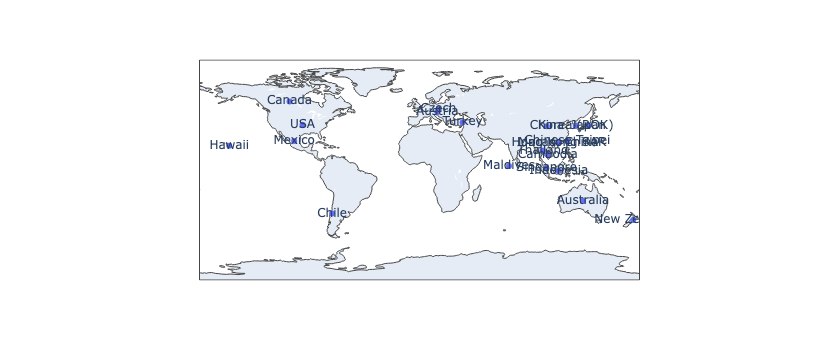

In [87]:
fig = px.scatter_geo(geo_df, lat='latitude', lon='longitude', text='Country')
fig.show()

# Google Trend
https://trends.google.com/trends/

In [88]:
trend_df = pd.read_csv('./data/downloaded/CovidGoogleTrend.csv', header=1)

In [89]:
trend_df['Week'] = pd.to_datetime(trend_df['Week'])
trend_df = trend_df.rename(columns={'covid: (Worldwide)': 'GlobalCovidTrend'})
trend_df['GlobalCovidTrend'] = trend_df['GlobalCovidTrend'].replace({'<1': '0'}).astype(int)

In [90]:
trend_df

Week  GlobalCovidTrend
0   2018-07-22                 0
1   2018-07-29                 0
2   2018-08-05                 0
3   2018-08-12                 0
4   2018-08-19                 0
..         ...               ...
256 2023-06-18                 3
257 2023-06-25                 3
258 2023-07-02                 3
259 2023-07-09                 3
260 2023-07-16                 3

[261 rows x 2 columns]

In [91]:
trend_df = trend_df.set_index('Week')
trend_df = trend_df.reindex(pd.DatetimeIndex(pd.date_range(start='2018-06-01', end='2024-08-01', freq='W')))

In [92]:
trend_df.iloc[-1, 0] = 0.0
trend_df.iloc[-10, 0] = 1.0
trend_df.iloc[-30, 0] = 2.0
trend_df.iloc[-50, 0] = 3.0
trend_df = trend_df.interpolate('bfill')
trend_df = trend_df.resample('MS').mean()
trend_df = trend_df.reset_index(names='Date')

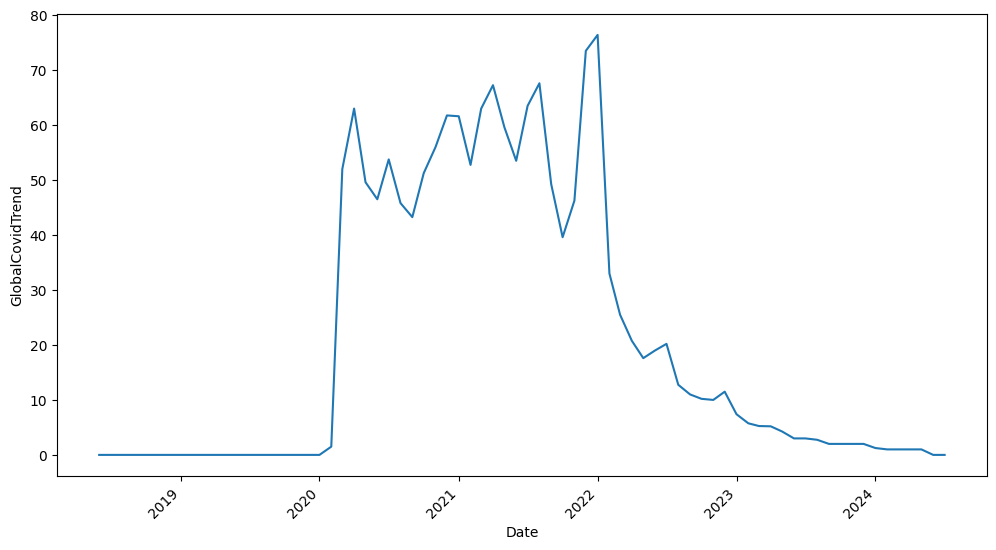

In [93]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=trend_df, x='Date', y='GlobalCovidTrend', ax=ax)
plt.xticks(rotation=45, ha='right');

In [94]:
trend_df.to_csv('./data/GoogleTrend.csv', index=False)

# Climate Data
https://crudata.uea.ac.uk/cru/data/hrg/cru_ts_4.07/crucy.2304181636.v4.07/countries/

In [95]:
climate_dir = './data/historical_climate'

In [96]:
prec_df = []
for filename in os.listdir(climate_dir):
    if filename.endswith('.pre.per'):
        with open(os.path.join(climate_dir, filename), 'r') as f:
            next(f); next(f); next(f);
            df = pd.read_fwf(f)
            df = pd.melt(df, id_vars=['YEAR'], value_vars=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC'], var_name='Month', value_name='Precipitation')
            df['Date'] = pd.to_datetime(df['YEAR'].astype(str) + '-' + df['Month'].astype(str).str.title(), format='%Y-%b')
            df = df[df['Date'] >= '1979-01-01']
            df['Country'] = filename.split('.')[-3]
            df = df.drop(columns=['YEAR', 'Month']).sort_values('Date', ignore_index=True)
            df[df['Precipitation'] < -500] = np.nan
            prec_df.append(df)
prec_df = pd.concat(prec_df, ignore_index=True)
prec_df['Country'] = prec_df['Country'].replace({'South_Korea': 'Korea (ROK)', 'Hong_Kong': 'Hong Kong SAR', 'Czech_Republic': 'Czech', 'Macau': 'Macao, China', 'New_Zealand': 'New Zealand'})

In [97]:
taiwan_prec_df = pd.read_csv('./data/historical_climate/variability-and-trends-of-precipitation-across-seasonal-cycle,-1971-2020;-taiwan,-china.csv')
temp = []
for col in ['1971-1980','1981-1990','1991-2000','2001-2010','2011-2020']:
    start, end = col.split('-')
    start, end = int(start), int(end) + 1
    for i, year in enumerate(range(start, end)):
        for month in taiwan_prec_df['month'].unique():
            temp.append([f'{year}-{month.title()}', taiwan_prec_df[taiwan_prec_df['month'] == month][col].iloc[i], 'Chinese Taipei'])
taiwan_prec_df = pd.DataFrame(temp, columns=['Date', 'Precipitation', 'Country'])
taiwan_prec_df['Date'] = pd.to_datetime(taiwan_prec_df['Date'], format='%Y-%b')

In [98]:
prec_df = pd.concat([prec_df, taiwan_prec_df], ignore_index=True)

In [99]:
tmp_df = []
for filename in os.listdir(climate_dir):
    if filename.endswith('.tmp.per'):
        with open(os.path.join(climate_dir, filename), 'r') as f:
            next(f); next(f); next(f);
            df = pd.read_fwf(f)
            df = pd.melt(df, id_vars=['YEAR'], value_vars=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC'], var_name='Month', value_name='Temperature')
            df['Date'] = pd.to_datetime(df['YEAR'].astype(str) + '-' + df['Month'].astype(str).str.title(), format='%Y-%b')
            df = df[df['Date'] >= '1979-01-01']
            df['Country'] = filename.split('.')[-3]
            df = df.drop(columns=['YEAR', 'Month']).sort_values('Date', ignore_index=True)
            df[df['Temperature'] < -500] = np.nan
            tmp_df.append(df)
tmp_df = pd.concat(tmp_df, ignore_index=True)
tmp_df['Country'] = tmp_df['Country'].replace({'South_Korea': 'Korea (ROK)', 'Hong_Kong': 'Hong Kong SAR', 'Czech_Republic': 'Czech', 'Macau': 'Macao, China', 'New_Zealand': 'New Zealand'})

In [100]:
taiwan_tmp_df = pd.read_csv('./data/historical_climate/variability-and-trends-of-mean-temperature-across-seasonal-cycle,-1971-2020;-taiwan,-china.csv')
temp = []
for col in ['1971-1980','1981-1990','1991-2000','2001-2010','2011-2020']:
    start, end = col.split('-')
    start, end = int(start), int(end) + 1
    for i, year in enumerate(range(start, end)):
        for month in taiwan_tmp_df['month'].unique():
            temp.append([f'{year}-{month.title()}', taiwan_tmp_df[taiwan_tmp_df['month'] == month][col].iloc[i], 'Chinese Taipei'])
taiwan_tmp_df = pd.DataFrame(temp, columns=['Date', 'Temperature', 'Country'])
taiwan_tmp_df['Date'] = pd.to_datetime(taiwan_tmp_df['Date'], format='%Y-%b')

In [101]:
tmp_df = pd.concat([tmp_df, taiwan_tmp_df], ignore_index=True)

In [102]:
# scrape more data from https://www.cwb.gov.tw/V8/E/C/Statistics/monthlydata.html
def get_taiwan_climate(year, month):
    headers = {
        'authority': 'www.cwb.gov.tw',
        'accept': '*/*',
        'accept-language': 'en-GB,en-US;q=0.9,en;q=0.8',
        # 'cookie': '_gid=GA1.3.1937064269.1687792273; _ga_K6HENP0XVS=GS1.1.1687792272.1.0.1687792272.60.0.0; _ga=GA1.1.953376534.1687792273; _clck=85bxcc|2|fcs|0|1272; _ga_7677B4JT3Q=GS1.1.1687792272.1.1.1687792599.60.0.0; _clsk=4otwy3|1687798375590|1|0|z.clarity.ms/collect; TS010c55bd=0107dddfef07f8de16ce39fb67652235307bfea871cbcb7b24530de90a1f33e4ba100b2da67b4afb2bb8af4bfad8ad947d704f5632',
        'referer': 'https://www.cwb.gov.tw/V8/E/C/Statistics/monthlydata.html',
        'sec-ch-ua': '"Not.A/Brand";v="8", "Chromium";v="114", "Google Chrome";v="114"',
        'sec-ch-ua-mobile': '?0',
        'sec-ch-ua-platform': '"macOS"',
        'sec-fetch-dest': 'empty',
        'sec-fetch-mode': 'cors',
        'sec-fetch-site': 'same-origin',
        'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36',
        'x-requested-with': 'XMLHttpRequest',
    }

    params = {
        'ID': str(datetime.now().microsecond%1000),
    }

    response = requests.get(
        f'https://www.cwb.gov.tw/V8/E/C/Statistics/MonthlyData/MOD/{year}_{month}.html',
        params=params,
        headers=headers,
    )
    df = pd.read_html('<table>' + response.text + '\n</table>')[0].replace('T', 0).replace('X', np.nan)
    mean_temp = df[1].astype(float).mean() #[~df[0].isin(['Yushan', 'Alishan', 'Matsu'])]
    mean_prec = df[4].astype(float).mean()
    return mean_temp, mean_prec

In [103]:
final_scraped = []
for year in range(2021, 2024):
    for month in range(1, 13):
        if year == 2023 and month > 6:
            continue
        mean_temp, mean_prec = get_taiwan_climate(year, month)
        final_scraped.append([f'{year}-{month}-01', mean_temp, mean_prec])
        time.sleep(1)
scraped_taiwan_df = pd.DataFrame(final_scraped, columns=['Date', 'Temperature', 'Precipitation'])
scraped_taiwan_df['Country'] = 'Chinese Taipei'
scraped_taiwan_df['Date'] = pd.to_datetime(scraped_taiwan_df['Date'])

In [104]:
prec_df = pd.concat([prec_df, scraped_taiwan_df[['Date', 'Precipitation', 'Country']]], ignore_index=True)
tmp_df = pd.concat([tmp_df, scraped_taiwan_df[['Date', 'Temperature', 'Country']]], ignore_index=True)

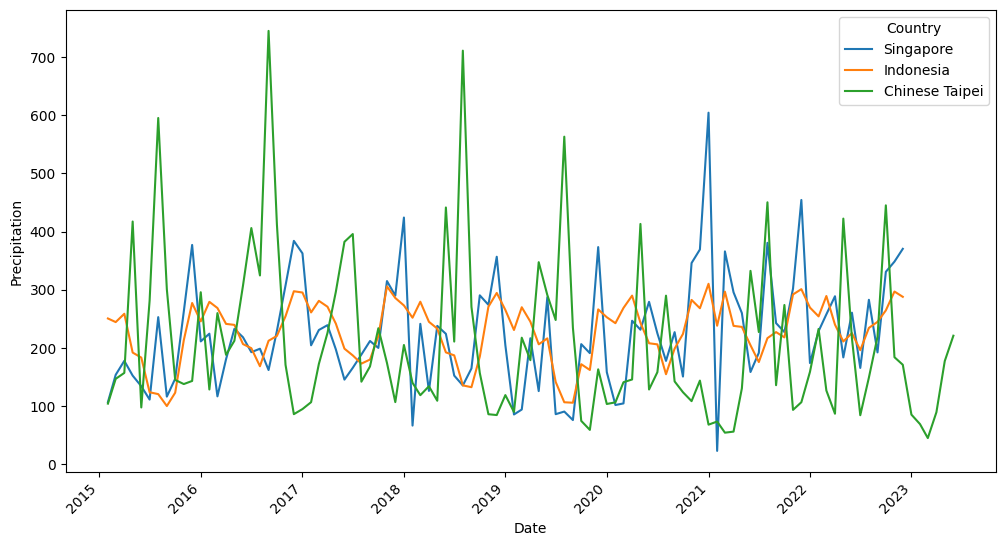

In [105]:
_ = plot_data(prec_df[prec_df['Date'] > '2015-01-01'], country=['Indonesia', 'Singapore', 'Chinese Taipei'], column='Precipitation', date_col='Date')

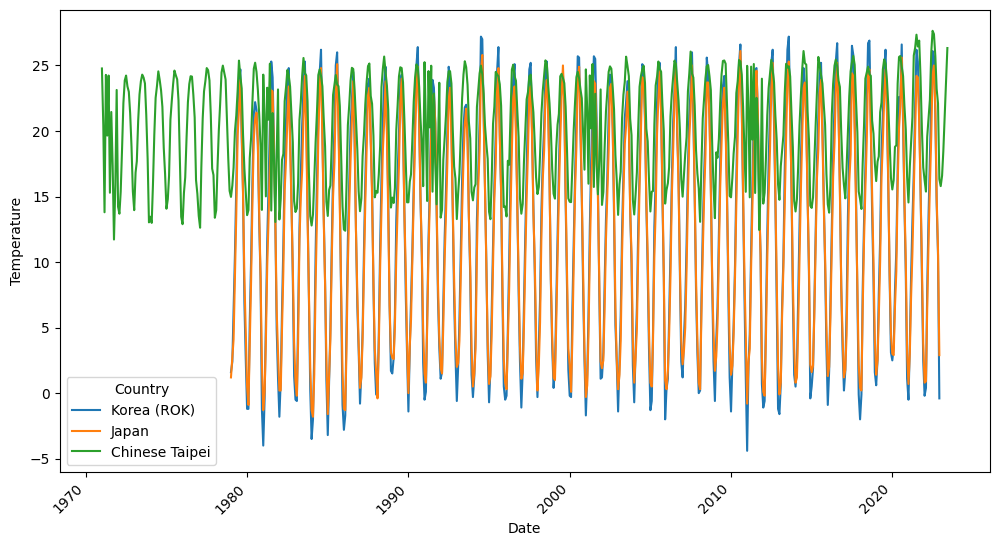

In [106]:
_ = plot_data(tmp_df, country=['Japan', 'Korea (ROK)', 'Chinese Taipei'], column='Temperature', date_col='Date')

In [107]:
prec_df.to_csv('./data/Precipitation.csv', index=False)
tmp_df.to_csv('./data/MeanTemperature.csv', index=False)

# Global Disaster
Leaving this for future work
https://public.emdat.be/about

In [108]:
dis_df = pd.read_excel('./data/downloaded/emdat_public_2023_06_26_query_uid-JXA6oc.xlsx', header=6)

/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default



In [109]:
# drop disaster that doesnt last at least a month
dis_df = dis_df[~((dis_df['Start Year'] == dis_df['End Year']) & (dis_df['Start Month'] == dis_df['End Month']))]
# drop null month since we cant pinpoint the exact date
dis_df = dis_df[dis_df['Start Month'].notnull() & dis_df['End Month'].notnull()]

In [110]:
dis_df.head()

Dis No  Year   Seq Glide Disaster Group Disaster Subgroup  \
0    1979-9200-HKG  1979  9200   NaN        Natural    Climatological   
79   1983-9019-CHN  1983  9019   NaN        Natural    Climatological   
83   1983-9308-HKG  1983  9308   NaN        Natural    Climatological   
89   1984-9211-CAN  1984  9211   NaN        Natural    Climatological   
102  1985-0201-CAN  1985   201   NaN        Natural    Meteorological   

    Disaster Type  Disaster Subtype Disaster Subsubtype Event Name    Country  \
0         Drought           Drought                 NaN        NaN  Hong Kong   
79        Drought           Drought                 NaN        NaN      China   
83        Drought           Drought                 NaN        NaN  Hong Kong   
89        Drought           Drought                 NaN        NaN     Canada   
102         Storm  Convective storm             Tornado        NaN     Canada   

     ISO            Region Continent  \
0    HKG      Eastern Asia      Asia   
79   CHN      Eastern Asia      Asia   
83   HKG      Eastern Asia      Asia   
89   CAN  Northern America  Americas   
102  CAN  Northern America  Americas   

                                              Location Origin Associated Dis  \
0                                                  NaN    NaN       Wildfire   
79                                               Tibet    NaN            NaN   
83                                                 NaN    NaN            NaN   
89   Quebec, Prince Edouard Islands, Alberta, Saska...    NaN            NaN   
102                                    Ontario Central    NaN            NaN   

    Associated Dis2 OFDA Response Appeal Declaration  \
0               NaN           NaN    NaN         NaN   
79              NaN           NaN    NaN         NaN   
83              NaN           NaN    NaN         NaN   
89              NaN           NaN    NaN         NaN   
102             NaN           NaN     No          No   

     AID Contribution ('000 US$)  Dis Mag Value Dis Mag Scale Latitude  \
0                            NaN            NaN           Km2      NaN   
79                           NaN            NaN           Km2      NaN   
83                           NaN            NaN           Km2      NaN   
89                           NaN            NaN           Km2      NaN   
102                          NaN            NaN           Kph      NaN   

    Longitude Local Time River Basin  Start Year  Start Month  Start Day  \
0         NaN        NaN         NaN        1979         10.0        NaN   
79        NaN        NaN         NaN        1983          1.0        NaN   
83        NaN        NaN         NaN        1983         10.0        NaN   
89        NaN        NaN         NaN        1984          1.0        NaN   
102       NaN        NaN         NaN        1985          5.0       29.0   

     End Year  End Month  End Day  Total Deaths  No Injured  No Affected  \
0        1979       12.0      NaN           NaN         NaN          NaN   
79       1983        8.0      NaN           NaN         NaN          NaN   
83       1983       12.0      NaN           NaN         NaN          NaN   
89       1985        3.0      NaN           NaN         NaN      30000.0   
102      1985        6.0      1.0          12.0       200.0          NaN   

     No Homeless  Total Affected  Reconstruction Costs ('000 US$)  \
0            NaN             NaN                              NaN   
79           NaN             NaN                              NaN   
83           NaN             NaN                              NaN   
89           NaN         30000.0                              NaN   
102        800.0          1000.0                              NaN   

     Reconstruction Costs, Adjusted ('000 US$)  Insured Damages ('000 US$)  \
0                                          NaN                         NaN   
79                                         NaN                         NaN   
83                 

In [111]:
dis_df['Disaster Type'].value_counts()

Disaster Type
Flood                     233
Storm                      98
Drought                    51
Wildfire                   51
Extreme temperature        29
Epidemic                   24
Volcanic activity           7
Landslide                   5
Industrial accident         3
Miscellaneous accident      3
Mass movement (dry)         1
Transport accident          1
Name: count, dtype: int64

In [112]:
dis_df[dis_df['Disaster Type'].isin(['Miscellaneous accident', 'Transport accident', 'Mass movement (dry)', 'Complex Disasters', 'Industrial accident'])]

Dis No  Year  Seq Glide Disaster Group Disaster Subgroup  \
301   1981-0310-JPN  1981  310   NaN  Technological     Technological   
1327  1992-0010-TUR  1992   10   NaN        Natural       Geophysical   
2385  2000-0429-JPN  2000  429   NaN  Technological     Technological   
3504  2005-0764-CAN  2005  764   NaN  Technological     Technological   
4078  2009-0181-CHN  2009  181   NaN  Technological     Technological   
4178  2008-0438-JPN  2008  438   NaN  Technological     Technological   
5298  2015-0555-TUR  2015  555   NaN  Technological     Technological   
6226  2022-0710-KOR  2022  710   NaN  Technological     Technological   

               Disaster Type Disaster Subtype Disaster Subsubtype  \
301      Industrial accident         Gas leak                 NaN   
1327     Mass movement (dry)        Avalanche                 NaN   
2385     Industrial accident        Poisoning                 NaN   
3504  Miscellaneous accident            Other                 NaN   
4078     Industrial accident            Other                 NaN   
4178  Miscellaneous accident             Fire                 NaN   
5298      Transport accident            Water                 NaN   
6226  Miscellaneous accident            Other                 NaN   

                 Event Name                  Country  ISO            Region  \
301         Nuclear central                    Japan  JPN      Eastern Asia   
1327                    NaN                   Turkey  TUR      Western Asia   
2385                   Milk                    Japan  JPN      Eastern Asia   
3504         Food poisoning                   Canada  CAN  Northern America   
4078  Atmospheric pollution                    China  CHN      Eastern Asia   
4178             Video shop                    Japan  JPN      Eastern Asia   
5298               Migrants                   Turkey  TUR      Western Asia   
6226               Stampede  Korea (the Republic of)  KOR      Eastern Asia   

     Continent                                           Location Origin  \
301       Asia                                            Tsuruga    NaN   
1327      Asia  Sirnak, Siirt, Elazig, Batman, Bingol, Diyarba...    NaN   
2385      Asia                                         Osaka area    NaN   
3504  Americas                                            Ontario    NaN   
4078      Asia                                     Jilin province    NaN   
4178      Asia                                              Osaka    NaN   
5298      Asia                                           Egee sea    NaN   
6226      Asia                                              Seoul    NaN   

     Associated Dis Associated Dis2 OFDA Response Appeal Declaration  \
301             NaN             NaN           NaN     No          No   
1327            NaN             NaN           Yes     No          No   
2385            NaN             NaN           NaN     No          No   
3504            NaN             NaN           NaN     No          No   
4078            NaN             NaN           NaN     No          No   
4178            NaN             NaN           NaN     No          No   
5298            NaN             NaN           NaN     No          No   
6226            NaN             NaN           NaN    NaN         NaN   

      AID Contribution ('000 US$)  Dis Mag Value Dis Mag Scale Latitude  \
301                           NaN            NaN            m3      NaN   
1327                          NaN            NaN           NaN      NaN   
2385                          NaN            NaN            m3      NaN   
3504                          NaN            NaN           NaN      NaN   
4078                          NaN            NaN            m3      NaN   
4178                          NaN            NaN           NaN      NaN   
5298                          NaN            NaN           NaN      NaN   
6226                          NaN            NaN           NaN      NaN   

     Longit

In [113]:
dis_df = dis_df[dis_df['Disaster Type'].isin(['Flood', 'Storm', 'Drought', 'Wildfire', 'Extreme temperature', 'Epidemic', 'Landslide', 'Volcanic activity'])]

In [114]:
dis_df['StartDate'] = pd.to_datetime(dis_df['Start Year'].astype(int).astype(str) + '-' + dis_df['Start Month'].astype(int).astype(str) + '-01')
dis_df['EndDate'] = pd.to_datetime(dis_df['End Year'].astype(int).astype(str) + '-' + dis_df['End Month'].astype(int).astype(str) + '-01')
dis_df['Country'] = dis_df['Country'].replace({'Hong Kong': 'Hong Kong SAR', 'United States of America (the)': 'USA', 'Korea (the Republic of)': 'Korea (ROK)', 
                                               'Taiwan (Province of China)': 'Chinese Taipei', 'Czech Republic (the)': 'Czech'})

In [115]:
dis_df['Country'].unique()

array(['Hong Kong SAR', 'China', 'Canada', 'Indonesia', 'Japan', 'USA',
       'Australia', 'Austria', 'Chile', 'Maldives', 'New Zealand',
       'Thailand', 'Mexico', 'Cambodia', 'Korea (ROK)', 'Chinese Taipei',
       'Singapore', 'Turkey', 'Czech'], dtype=object)

In [116]:
temp = dis_df[(dis_df['Country'] == 'USA') & (dis_df['Location'].str.contains('hawaii', case=False))].copy()
temp['Country'] = 'Hawaii'
dis_df = pd.concat([dis_df, temp], ignore_index=True)

In [117]:
dis_df[['Disaster Group', 'Disaster Subgroup', 'Disaster Type', 'Disaster Subtype', 'Disaster Subsubtype', 'Event Name', 'Country', 'Location', 'StartDate', 'EndDate', 
        'Total Deaths', 'Total Affected', "Total Damages ('000 US$)", "Total Damages, Adjusted ('000 US$)"]]

Disaster Group Disaster Subgroup Disaster Type  Disaster Subtype  \
0          Natural    Climatological       Drought           Drought   
1          Natural    Climatological       Drought           Drought   
2          Natural    Climatological       Drought           Drought   
3          Natural    Climatological       Drought           Drought   
4          Natural    Meteorological         Storm  Convective storm   
..             ...               ...           ...               ...   
465        Natural    Climatological      Wildfire               NaN   
466        Natural    Climatological      Wildfire               NaN   
467        Natural      Hydrological         Flood               NaN   
468        Natural    Meteorological         Storm  Convective storm   
469        Natural        Biological      Epidemic     Viral disease   

    Disaster Subsubtype                                 Event Name  \
0                   NaN                                        NaN   
1                   NaN                                        NaN   
2                   NaN                                        NaN   
3                   NaN                                        NaN   
4               Tornado                                        NaN   
..                  ...                                        ...   
465                 NaN  McBride, Nogal Canyon, Hermits Peak Fires   
466                 NaN         Calf Canyon and Hermits Peak Fires   
467                 NaN                                        NaN   
468             Tornado                                        NaN   
469                 NaN          Acute respiratory syndrome (SARS)   

           Country                                           Location  \
0    Hong Kong SAR                                                NaN   
1            China                                              Tibet   
2    Hong Kong SAR                                                NaN   
3           Canada  Quebec, Prince Edouard Islands, Alberta, Saska...   
4           Canada                                    Ontario Central   
..             ...                                                ...   
465            USA          Lincoln, San Miguel Counties (New Mexico)   
466            USA  Mora, Colfax, Lincoln, San Miguel, Valencia Co...   
467            USA  North Dakota and northern Minnesota (central-n...   
468            USA  Memphis (Tennessee); Owen and Sullivan countie...   
469         Hawaii  Alabama, California, Connecticut, Georgia, Haw...   

     StartDate    EndDate  Total Deaths  Total Affected  \
0   1979-10-01 1979-12-01           NaN             NaN   
1   1983-01-01 1983-08-01           NaN             NaN   
2   1983-10-01 1983-12-01           NaN             NaN   
3   1984-01-01 1985-03-01           NaN         30000.0   
4   1985-05-01 1985-06-01          12.0          1000.0   
..         ...        ...           ...             ...   
465 2022-04-01 2022-05-01           2.0           649.0   
466 2022-04-01 2022-06-01           NaN           894.0   
467 2022-04-01 2022-05-01           NaN             NaN   
468 2023-03-01 2023-04-01          31.0          6279.0   
469 2003-02-01 2003-07-01           NaN            29.0   

     Total Damages ('000 US$)  Total Damages, Adjusted ('000 US$)  
0                         NaN                                 NaN  
1                         NaN                                 NaN  
2                         NaN                                 NaN  
3                   1000000.0                           2817149.0  
4                    117000.0                            318320.0  
..                        ...                                 ...  
465                  155000.0                            155000.0  
466                       NaN                                 NaN  
467                       NaN                                 NaN  
468                  100000.0   

In [118]:
dis_df[['Disaster Group', 'Disaster Subgroup', 'Disaster Type', 'Disaster Subtype', 'Disaster Subsubtype', 'Event Name', 'Country', 'Location', 'StartDate', 'EndDate', 
        'Total Deaths', 'Total Affected', "Total Damages ('000 US$)", "Total Damages, Adjusted ('000 US$)"]].to_csv('./data/GlobalDisaster.csv', index=False)